# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, count, isnull, udf, when

from pyspark.ml.classification import RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
from workspace_utils import active_session

import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
# create a Spark session and load the data set "mini_sparkify_event_data.json"
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Project") \
    .getOrCreate()

path = "mini_sparkify_event_data.json"
df = spark.read.json(path)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

Clean up:
- Check and delete records with userid or sessionid == null
- Check for other NaNs

In [3]:
# lets have a first look at the data
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [4]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
artist,Martha Tilston,Five Iron Frenzy,Adam Lambert,Enigma,Daft Punk
auth,Logged In,Logged In,Logged In,Logged In,Logged In
firstName,Colin,Micah,Colin,Micah,Colin
gender,M,M,M,M,M
itemInSession,50,79,51,80,52
lastName,Freeman,Long,Freeman,Long,Freeman
length,277.89,236.094,282.827,262.713,223.608
level,paid,free,paid,free,paid
location,"Bakersfield, CA","Boston-Cambridge-Newton, MA-NH","Bakersfield, CA","Boston-Cambridge-Newton, MA-NH","Bakersfield, CA"
method,PUT,PUT,PUT,PUT,PUT


In [5]:
# Show the schema of the loaded data
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [7]:
# A closer look at userId and sessionId as these are our two important keys that we will use for the analysis
# UserId seem to have some empty cells - to be examined more in detail below.
df.describe("userId", "sessionId").show()

+-------+-----------------+-----------------+
|summary|           userId|        sessionId|
+-------+-----------------+-----------------+
|  count|           286500|           286500|
|   mean|59682.02278593872|1041.526554973822|
| stddev|109091.9499991047|726.7762634630741|
|    min|                 |                1|
|    max|               99|             2474|
+-------+-----------------+-----------------+



In [8]:
# list all available pages that users in the log file visited
df.select("page").dropDuplicates().sort("page").show(100)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [9]:
# Check where we have null values (not empty cells)
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [10]:
# total number of log events
df.count()

286500

In [11]:
# check number of null values in userId and sessionId
print("Number of null values in userId column: ", format(df.where(col('userId').isNull()).count()))
print("Number of null values in sessionId column: ", format(df.where(col('sessionId').isNull()).count()))

Number of null values in userId column:  0
Number of null values in sessionId column:  0


In [12]:
# check number of empty cells in userId and sessionId
print("Number of empty values in userId column: ", format(df.where(col('userId') == "").count()))
print("Number of empty values in sessionId column: ", format(df.where(col('sessionId') == "").count()))

Number of empty values in userId column:  8346
Number of empty values in sessionId column:  0


In [13]:
# clean up: remove all rows where the userId is empty as these are from events where a user was 
# not logged in which is non-relevant for our churn analysis
df_clean = df.filter(df.userId != "")

In [14]:
df_clean.describe("userId", "sessionId").show()

+-------+-----------------+------------------+
|summary|           userId|         sessionId|
+-------+-----------------+------------------+
|  count|           278154|            278154|
|   mean|59682.02278593872|1042.5616241362698|
| stddev|109091.9499991047| 726.5010362219813|
|    min|               10|                 1|
|    max|               99|              2474|
+-------+-----------------+------------------+



In [15]:
# number of log events after clean up
df_clean.count()

278154

In [16]:
# Add the hour of day when the song was played to the data frame as a feature
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
df_clean = df_clean.withColumn("hour", get_hour(df_clean.ts))

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [17]:
# Get the number of users in the data set for all pages
df_clean.select('userId').distinct().count()

225

In [18]:
# Get the number of users that visited the page cancellation confirmation
df_clean.filter("page == 'Cancellation Confirmation'").select('userId').distinct().count()

52

In [19]:
# Get the number of users that visited the page downgrade
df_clean.filter("page == 'Downgrade'").select('userId').distinct().count()

154

In [20]:
# Filter the data frame to only contain churn events
df_churn = df_clean.where(df_clean.auth=="Cancelled")

In [21]:
df_churn.select(['userId', 'sessionId','page', 'level','hour', 'auth']).show(100)

+------+---------+--------------------+-----+----+---------+
|userId|sessionId|                page|level|hour|     auth|
+------+---------+--------------------+-----+----+---------+
|    18|      514|Cancellation Conf...| paid|  22|Cancelled|
|    32|      540|Cancellation Conf...| paid|  23|Cancelled|
|   125|      174|Cancellation Conf...| free|   6|Cancelled|
|   105|      508|Cancellation Conf...| paid|  22|Cancelled|
|    17|      797|Cancellation Conf...| paid|  23|Cancelled|
|   143|      843|Cancellation Conf...| free|   9|Cancelled|
|   101|      842|Cancellation Conf...| paid|   0|Cancelled|
|   129|      802|Cancellation Conf...| paid|   2|Cancelled|
|   121|      881|Cancellation Conf...| paid|   9|Cancelled|
|    51|      934|Cancellation Conf...| paid|   9|Cancelled|
|    87|     1092|Cancellation Conf...| paid|  17|Cancelled|
|   122|     1029|Cancellation Conf...| paid|  21|Cancelled|
|    12|     1072|Cancellation Conf...| paid|   9|Cancelled|
|    58|     1112|Cancel

In [22]:
# create a churn column in the dataframe that is 1 for all the events that are from users that have churned
list_churnusers = [(row['userId']) for row in df_churn.collect()]

df_clean_churn = df_clean.withColumn("churn", when(col("userId").isin(list_churnusers),1).otherwise(0))

In [23]:
df_clean_churn.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='2', churn=0),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', hour='2', churn=0)]

Ideas for features:
- Churns per Gender
- Churns per Level
- Number of songs listened per session
- Number of songs played / total number of events per user
- Number of songs added to playlists 
- Number of friends added
- Number of errors
- Number of adverts
- Number of thumbs up
- Number of thumbs down

In [24]:
# get some more information on how the features behave for users with or without churn.
df_clean_churn.select(['userId','churn']).distinct().groupBy('churn').count().show()


+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [25]:
df_clean_churn.select(['userId','gender','churn']).distinct().groupBy('gender', 'churn').count().show()


+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     M|    1|   32|
|     F|    0|   84|
|     F|    1|   20|
|     M|    0|   89|
+------+-----+-----+



In [26]:
df_clean_churn.select(['userId','level','churn']).distinct().groupBy('level', 'churn').count().show()


+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| paid|    0|  129|
| free|    0|  149|
| paid|    1|   36|
| free|    1|   46|
+-----+-----+-----+



In [27]:
df_clean_churn.select(['userId', 'sessionId','churn']).distinct().groupBy('churn').count().show()


+-----+-----+
|churn|count|
+-----+-----+
|    1|  537|
|    0| 2639|
+-----+-----+



In [28]:
df_clean_churn.where('page="NextSong"').select(['userId', 'churn']).distinct().groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [29]:
df_clean_churn.where('page="Add Friend"').select(['userId', 'churn']).distinct().groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   44|
|    0|  162|
+-----+-----+



In [30]:
df_clean_churn.where('page="Add to Playlist"').select(['userId', 'churn']).distinct().groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   50|
|    0|  165|
+-----+-----+



In [31]:
df_clean_churn.where('page="Error"').select(['userId', 'churn']).distinct().groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   22|
|    0|   95|
+-----+-----+



In [32]:
df_clean_churn.where('page="Roll Advert"').select(['userId', 'churn']).distinct().groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   50|
|    0|  157|
+-----+-----+



In [33]:
df_clean_churn.where('page="Thumbs Up"').select(['userId', 'churn']).distinct().groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   50|
|    0|  170|
+-----+-----+



In [34]:
df_clean_churn.where('page="Thumbs Down"').select(['userId', 'churn']).distinct().groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   48|
|    0|  155|
+-----+-----+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [35]:
# Now its time create the features for each userId
# Feature 1: Gender
f1 = df_clean_churn.select('userId', 'gender').dropDuplicates().replace(['F', 'M'], ['0', '1'], 'gender').select('userId', col('gender').cast('int'))

f1.show()

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
|    72|     0|
|300023|     0|
|    39|     0|
|100010|     0|
|    40|     0|
|    94|     0|
|    35|     0|
|    75|     0|
|   116|     0|
|200001|     1|
|200020|     1|
|100008|     0|
|200015|     1|
|   100|     1|
|100006|     0|
|300005|     0|
|    25|     0|
+------+------+
only showing top 20 rows



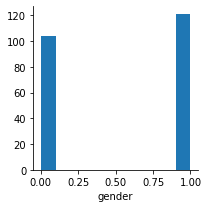

In [36]:
f1p = f1.toPandas()
g = sns.FacetGrid(f1p)
g.map(plt.hist, "gender");

In [37]:
# Feature 2: Level
f2 = df_clean_churn.select('userId', 'level').dropDuplicates().replace(['free', 'paid'], ['0', '1'], 'level').select('userId', col('level').cast('int'))

f2.show()

+------+-----+
|userId|level|
+------+-----+
|100021|    0|
|200021|    0|
|200001|    0|
|     6|    0|
|300022|    1|
|   132|    0|
|   112|    0|
|    79|    0|
|200008|    0|
|    16|    1|
|200007|    1|
|300015|    0|
|    39|    0|
|300014|    1|
|    61|    0|
|    56|    1|
|300014|    0|
|   100|    1|
|300024|    1|
|300023|    1|
+------+-----+
only showing top 20 rows



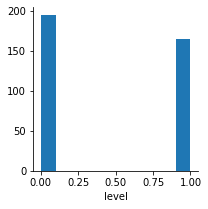

In [38]:
f2p = f2.toPandas()
g = sns.FacetGrid(f2p)
g.map(plt.hist, "level");

In [39]:
# Feature 3: Number of songs listened per session
f3  = df_clean_churn.where(df_clean_churn.page == "NextSong").groupby(['userId', 'sessionId']).count().groupby('userId').agg({'count' : 'avg'}).withColumnRenamed('avg(count)', 'songs_per_session')

f3.show()

+------+------------------+
|userId| songs_per_session|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
|     7|21.428571428571427|
|    54| 81.17142857142858|
|    15|136.71428571428572|
|   155|136.66666666666666|
|100014|42.833333333333336|
|   132|             120.5|
|   154|              28.0|
|   101|             179.7|
|    11|           40.4375|
|300017|59.540983606557376|
|   138|             138.0|
|    29| 89.05882352941177|
|    69|             125.0|
|100021|              46.0|
|    42| 87.14634146341463|
+------+------------------+
only showing top 20 rows



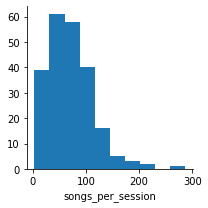

In [40]:
f3p = f3.toPandas()
g = sns.FacetGrid(f3p)
g.map(plt.hist, "songs_per_session");

In [41]:
# Feature 4 : Number of songs played / total number of events per user
f4 = df_clean_churn.select('userId', 'song').groupBy('userId').count().withColumnRenamed('count', 'total_songs')
f4.show()

+------+-----------+
|userId|total_songs|
+------+-----------+
|100010|        381|
|200002|        474|
|   125|         11|
|    51|       2464|
|   124|       4825|
|     7|        201|
|    54|       3437|
|    15|       2278|
|   155|       1002|
|   132|       2304|
|   154|        118|
|100014|        310|
|   101|       2149|
|    11|        848|
|   138|       2469|
|300017|       4428|
|    29|       3603|
|    69|       1342|
|100021|        319|
|    42|       4257|
+------+-----------+
only showing top 20 rows



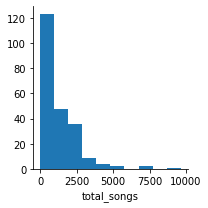

In [42]:
f4p = f4.toPandas()
g = sns.FacetGrid(f4p)
g.map(plt.hist, "total_songs");

In [43]:
# Feature 5: Number of songs added to playlists
f5 = df_clean_churn.select('userId', 'page').where(df_clean_churn.page == 'Add to Playlist').groupBy('userId').count().withColumnRenamed('count', 'playlist_adds')
f5.show()

+------+-------------+
|userId|playlist_adds|
+------+-------------+
|100010|            7|
|200002|            8|
|    51|           52|
|   124|          118|
|     7|            5|
|    15|           59|
|    54|           72|
|   155|           24|
|   132|           38|
|   154|            1|
|100014|            7|
|   101|           61|
|    11|           20|
|   138|           67|
|300017|          113|
|    29|           89|
|    69|           33|
|100021|            7|
|    42|          104|
|   112|            7|
+------+-------------+
only showing top 20 rows



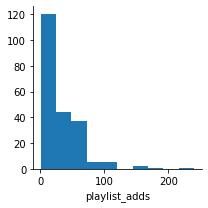

In [44]:
f5p = f5.toPandas()
g = sns.FacetGrid(f5p)
g.map(plt.hist, "playlist_adds");

In [45]:
# Feature 6: Number of friends added
f6 = df_clean_churn.select('userId', 'page').where(df.page == 'Add Friend').groupBy('userId').count().withColumnRenamed('count', 'friends_added')
f6.show()

+------+-------------+
|userId|friends_added|
+------+-------------+
|100010|            4|
|200002|            4|
|    51|           28|
|   124|           74|
|     7|            1|
|    54|           33|
|    15|           31|
|   155|           11|
|   132|           41|
|   154|            3|
|100014|            6|
|   101|           29|
|    11|            6|
|   138|           41|
|300017|           63|
|    29|           47|
|    69|           12|
|100021|            7|
|    42|           52|
|   112|            7|
+------+-------------+
only showing top 20 rows



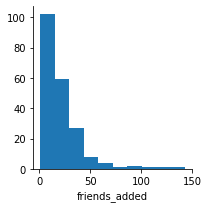

In [46]:
f6p = f6.toPandas()
g = sns.FacetGrid(f6p)
g.map(plt.hist, "friends_added");

In [47]:
# Feature 7: Number of errors
f7 = df_clean_churn.select('userId', 'page').where(df.page == 'Error').groupBy('userId').count().withColumnRenamed('count', 'errors')
f7.show()

+------+------+
|userId|errors|
+------+------+
|   124|     6|
|    51|     1|
|     7|     1|
|    15|     2|
|    54|     1|
|   155|     3|
|   132|     3|
|   101|     3|
|    11|     1|
|   138|     1|
|300017|     5|
|    69|     4|
|100021|     2|
|    42|     7|
|    73|     1|
|200010|     1|
|    30|     1|
|   113|     3|
|    59|     4|
|   146|     1|
+------+------+
only showing top 20 rows



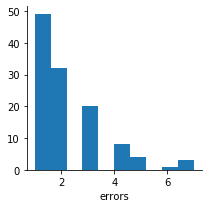

In [48]:
f7p = f7.toPandas()
g = sns.FacetGrid(f7p)
g.map(plt.hist, "errors");

In [49]:
# Feature 8: Number of adverts
f8 = df_clean_churn.select('userId', 'page').where(df.page == 'Roll Advert').groupBy('userId').count().withColumnRenamed('count', 'adverts')
f8.show()

+------+-------+
|userId|adverts|
+------+-------+
|100010|     52|
|200002|      7|
|   125|      1|
|     7|     16|
|   124|      4|
|    54|     47|
|    15|      1|
|   155|      8|
|   154|     10|
|   132|      2|
|100014|      2|
|   101|      8|
|    11|     39|
|   138|     17|
|300017|     11|
|    29|     22|
|    69|      3|
|100021|     30|
|    42|     10|
|   112|     21|
+------+-------+
only showing top 20 rows



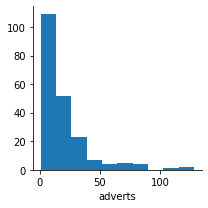

In [50]:
f8p = f8.toPandas()
g = sns.FacetGrid(f8p)
g.map(plt.hist, "adverts");

In [51]:
# Feature 9: Number of thumbs up
f9 = df_clean_churn.select('userId', 'page').where(df.page == 'Thumbs Up').groupBy('userId').count().withColumnRenamed('count', 'thumbs_up')
f9.show()

+------+---------+
|userId|thumbs_up|
+------+---------+
|100010|       17|
|200002|       21|
|    51|      100|
|   124|      171|
|     7|        7|
|    54|      163|
|    15|       81|
|   155|       58|
|   132|       96|
|   154|       11|
|100014|       17|
|   101|       86|
|    11|       40|
|   138|       95|
|300017|      303|
|    29|      154|
|    69|       72|
|100021|       11|
|    42|      166|
|   112|        9|
+------+---------+
only showing top 20 rows



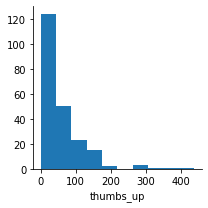

In [52]:
f9p = f9.toPandas()
g = sns.FacetGrid(f9p)
g.map(plt.hist, "thumbs_up");

In [53]:
# Feature 10: Number of thumbs down
f10 = df_clean_churn.select('userId', 'page').where(df.page == 'Thumbs Down').groupBy('userId').count().withColumnRenamed('count', 'thumbs_down')
f10.show()

+------+-----------+
|userId|thumbs_down|
+------+-----------+
|100010|          5|
|200002|          6|
|    51|         21|
|   124|         41|
|     7|          1|
|    15|         14|
|    54|         29|
|   155|          3|
|   132|         17|
|100014|          3|
|   101|         16|
|    11|          9|
|   138|         24|
|300017|         28|
|    29|         22|
|    69|          9|
|100021|          5|
|    42|         25|
|   112|          3|
|    73|          7|
+------+-----------+
only showing top 20 rows



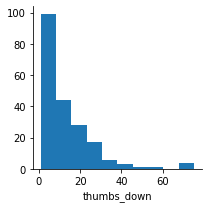

In [54]:
f10p = f10.toPandas()
g = sns.FacetGrid(f10p)
g.map(plt.hist, "thumbs_down");

In [55]:
churn = df_clean_churn.select('userId', col('churn').alias('churn')).dropDuplicates()
churn.show()

+------+-----+
|userId|churn|
+------+-----+
|    19|    0|
|100005|    1|
|200007|    0|
|300007|    1|
|    50|    0|
|200002|    0|
|    30|    0|
|     8|    0|
|100011|    1|
|100012|    1|
|     4|    0|
|    65|    0|
|   101|    1|
|    13|    0|
|   153|    0|
|    42|    0|
|100014|    1|
|    94|    0|
|    62|    0|
|   114|    0|
+------+-----+
only showing top 20 rows



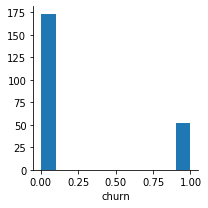

In [56]:
churnp = churn.toPandas()
g = sns.FacetGrid(churnp)
g.map(plt.hist, "churn");

In [57]:
# as a final step we combine all the features with the churn column into a feature_data dataframe
feature_data = f1.join(f2, 'userId', 'inner').join(f3, 'userId', 'inner').join(f4, 'userId', 'inner')\
             .join(f5, 'userId', 'inner').join(f6, 'userId', 'inner').join(f7, 'userId', 'inner')\
             .join(f8, 'userId', 'inner').join(f9, 'userId', 'inner').join(f10, 'userId', 'inner').join(churn, 'userId', 'inner').drop('userId')

feature_data.show()

+------+-----+------------------+-----------+-------------+-------------+------+-------+---------+-----------+-----+
|gender|level| songs_per_session|total_songs|playlist_adds|friends_added|errors|adverts|thumbs_up|thumbs_down|churn|
+------+-----+------------------+-----------+-------------+-------------+------+-------+---------+-----------+-----+
|     0|    1|157.83333333333334|       2220|           61|           36|     1|      1|       76|         10|    0|
|     0|    0|              85.0|        117|            3|            3|     1|     10|        6|          1|    0|
|     0|    0| 66.55555555555556|       2210|           63|           31|     3|      2|      169|         16|    0|
|     0|    1| 66.55555555555556|       2210|           63|           31|     3|      2|      169|         16|    0|
|     0|    1| 77.68932038834951|       9632|          240|          122|     7|    128|      388|         69|    0|
|     0|    0| 77.68932038834951|       9632|          240|     

In [58]:
# show the schema of our feature data frame
feature_data.printSchema()

root
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- songs_per_session: double (nullable = true)
 |-- total_songs: long (nullable = false)
 |-- playlist_adds: long (nullable = false)
 |-- friends_added: long (nullable = false)
 |-- errors: long (nullable = false)
 |-- adverts: long (nullable = false)
 |-- thumbs_up: long (nullable = false)
 |-- thumbs_down: long (nullable = false)
 |-- churn: integer (nullable = false)



In [59]:
# check for null values.
feature_data.select([count(when(isnull(c), c)).alias(c) for c in feature_data.columns]).show()

+------+-----+-----------------+-----------+-------------+-------------+------+-------+---------+-----------+-----+
|gender|level|songs_per_session|total_songs|playlist_adds|friends_added|errors|adverts|thumbs_up|thumbs_down|churn|
+------+-----+-----------------+-----------+-------------+-------------+------+-------+---------+-----------+-----+
|     0|    0|                0|          0|            0|            0|     0|      0|        0|          0|    0|
+------+-----+-----------------+-----------+-------------+-------------+------+-------+---------+-----------+-----+



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [60]:
# before we start the modelling we need to combine the features into a features vector
feature_columns = ['gender', 'level', 'songs_per_session', 'total_songs', 'playlist_adds', 'friends_added', 'errors', 'adverts', 'thumbs_up', 'thumbs_down']
assmbler = VectorAssembler(inputCols = feature_columns, outputCol = "vectorized_features")
feature_data = assmbler.transform(feature_data)
feature_data.show()

+------+-----+------------------+-----------+-------------+-------------+------+-------+---------+-----------+-----+--------------------+
|gender|level| songs_per_session|total_songs|playlist_adds|friends_added|errors|adverts|thumbs_up|thumbs_down|churn| vectorized_features|
+------+-----+------------------+-----------+-------------+-------------+------+-------+---------+-----------+-----+--------------------+
|     0|    1|157.83333333333334|       2220|           61|           36|     1|      1|       76|         10|    0|[0.0,1.0,157.8333...|
|     0|    0|              85.0|        117|            3|            3|     1|     10|        6|          1|    0|[0.0,0.0,85.0,117...|
|     0|    0| 66.55555555555556|       2210|           63|           31|     3|      2|      169|         16|    0|[0.0,0.0,66.55555...|
|     0|    1| 66.55555555555556|       2210|           63|           31|     3|      2|      169|         16|    0|[0.0,1.0,66.55555...|
|     0|    1| 77.68932038834951| 

In [61]:
# in order to enable our machine learning models to work with our data without getting bias though different scales
# we need to scale the data
scaler = StandardScaler(inputCol = 'vectorized_features', outputCol = "scaled_features", withStd = True, withMean = False)
scaler_model = scaler.fit(feature_data)
feature_data = scaler_model.transform(feature_data)

In [62]:
feature_data.head(1)

[Row(gender=0, level=1, songs_per_session=157.83333333333334, total_songs=2220, playlist_adds=61, friends_added=36, errors=1, adverts=1, thumbs_up=76, thumbs_down=10, churn=0, vectorized_features=DenseVector([0.0, 1.0, 157.8333, 2220.0, 61.0, 36.0, 1.0, 1.0, 76.0, 10.0]), scaled_features=DenseVector([0.0, 1.9949, 4.0969, 1.4356, 1.5989, 1.4748, 0.703, 0.039, 0.9731, 0.6632]))]

In [63]:
# here we prepare the data into label and features vector as well was renaming these to use the standard 
# column names used by the used classifiers.
feature_data_final = feature_data.select(['churn', 'scaled_features'])
feature_data_final = feature_data_final.selectExpr("churn as label", "scaled_features as features")

In [64]:
feature_data_final.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.0,1.9948931000...|
|    0|[0.0,0.0,2.206375...|
|    0|[0.0,0.0,1.727606...|
|    0|[0.0,1.9948931000...|
|    0|[0.0,1.9948931000...|
|    0|[0.0,0.0,2.016609...|
|    0|[0.0,0.0,1.160870...|
|    0|[0.0,1.9948931000...|
|    0|[0.0,1.9948931000...|
|    1|[1.99489310007777...|
|    0|[1.99489310007777...|
|    0|[1.99489310007777...|
|    0|[0.0,1.9948931000...|
|    0|[0.0,0.0,1.349782...|
|    0|[0.0,1.9948931000...|
|    0|[0.0,0.0,1.837101...|
|    0|[1.99489310007777...|
|    0|[1.99489310007777...|
|    0|[1.99489310007777...|
|    0|[0.0,1.9948931000...|
+-----+--------------------+
only showing top 20 rows



In [65]:
# splitting the data in training and testing data sets.
train_data , test_data = feature_data_final.randomSplit([0.7,0.3], seed = 42)

In [66]:
# Fitting a Random Forest Classifier
rfc = RandomForestClassifier()

mce_f1 = MulticlassClassificationEvaluator(metricName = 'f1')
parameter_grid = ParamGridBuilder().build()

cv_rf = CrossValidator(estimator = rfc, estimatorParamMaps = parameter_grid, evaluator = mce_f1, numFolds = 2)

cv_rf_model = cv_rf.fit(train_data)
cv_rf_model.avgMetrics

[0.7978859774114682]

In [67]:
# Evaluating the results with regard to f1 score and accuracy
test_result_rf = cv_rf_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
evaluator_ROC = BinaryClassificationEvaluator(rawPredictionCol='prediction', metricName='areaUnderROC')
print("f1 score: " + str(evaluator.evaluate(test_result_rf, {evaluator.metricName : "accuracy"})))
print("accuracy: " + str(evaluator.evaluate(test_result_rf, {evaluator.metricName : "f1"})))
print("area under ROC: " + str(evaluator_ROC.evaluate(test_result_rf, {evaluator.metricName : "areaUnderROC"})))

f1 score: 0.9473684210526315
accuracy: 0.9409578668648674
area under ROC: 0.7857142857142857


In [68]:
# Fitting a Gradient Boost Tree Classifier
gbtc = GBTClassifier(maxIter = 5, maxDepth = 5, seed = 42)

mce_f1 = MulticlassClassificationEvaluator(metricName = 'f1')
parameter_grid = ParamGridBuilder().build()

cv_gbtc = CrossValidator(estimator = gbtc, estimatorParamMaps = parameter_grid, evaluator = mce_f1, numFolds = 2)

cv_gbtc_model = cv_gbtc.fit(train_data)
cv_gbtc_model.avgMetrics

[0.8264942589242702]

In [69]:
# Evaluating the results with regard to f1 score and accuracy
test_result_gbtc = cv_gbtc_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
evaluator_ROC = BinaryClassificationEvaluator(rawPredictionCol='prediction', metricName='areaUnderROC')
print("f1 score: " + str(evaluator.evaluate(test_result_gbtc, {evaluator.metricName : "accuracy"})))
print("accuracy: " + str(evaluator.evaluate(test_result_gbtc, {evaluator.metricName : "f1"})))
print("area under ROC: " + str(evaluator_ROC.evaluate(test_result_gbtc, {evaluator.metricName : "areaUnderROC"})))

f1 score: 0.9298245614035088
accuracy: 0.9298245614035088
area under ROC: 0.8371428571428571


In [70]:
# Fitting a Linear SVC
lsvc = LinearSVC(maxIter = 10)

mce_f1 = MulticlassClassificationEvaluator(metricName = 'f1')
parameter_grid = ParamGridBuilder().build()

cv_lsvc = CrossValidator(estimator = lsvc, estimatorParamMaps = parameter_grid, evaluator = mce_f1, numFolds = 2)

cv_lsvc_model = cv_lsvc.fit(train_data)
cv_lsvc_model.avgMetrics

[0.6747413061916879]

In [71]:
# Evaluating the results with regard to f1 score and accuracy
test_result_lsvc = cv_lsvc_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
evaluator_ROC = BinaryClassificationEvaluator(rawPredictionCol='prediction', metricName='areaUnderROC')

print("f1 score: " + str(evaluator.evaluate(test_result_lsvc, {evaluator.metricName : "accuracy"})))
print("accuracy: " + str(evaluator.evaluate(test_result_lsvc, {evaluator.metricName : "f1"})))
print("area under ROC: " + str(evaluator_ROC.evaluate(test_result_lsvc, {evaluator.metricName : "areaUnderROC"})))

f1 score: 0.8771929824561403
accuracy: 0.8198065256599442
area under ROC: 0.5


After trying three different classifiers:
- Random Forest Classifier
- Gradent Boost Tree Classifier 
- Decision Tree Classifier

We see that the Gradient Boost Tree classifiere has the best scores: f1 score: 0.923 and 
accuracy: 0.927.

As a final step I will try to improve these results by performing a grid search to find the optimal hyperparameters for this problem. 

In [72]:
# Fitting a Gradient Boost Tree Classifier and using Grid Search to find the optimal hyperparameters
gbtc_final = GBTClassifier(maxIter = 5, maxDepth = 5, seed = 42)

mce_f1 = MulticlassClassificationEvaluator(metricName = 'f1')
parameter_grid_final = ParamGridBuilder().addGrid(gbtc_final.maxIter, [5, 10, 15, 20]).addGrid(gbtc_final.maxDepth, [5, 10]).build()

cv_gbtc_final = CrossValidator(estimator = gbtc_final, estimatorParamMaps = parameter_grid_final, evaluator = mce_f1, numFolds = 3)
cv_gbtc_model_final = cv_gbtc_final.fit(train_data)
cv_gbtc_model_final.avgMetrics

[0.833628480951707,
 0.847330685491605,
 0.8423179642227261,
 0.847330685491605,
 0.8505591938925272,
 0.847330685491605,
 0.8505591938925272,
 0.847330685491605]

In [73]:
# Evaluating the results with regard to f1 score and accuracy
test_result_gbtc_final = cv_gbtc_model_final.transform(test_data)

evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
evaluator_ROC = BinaryClassificationEvaluator(rawPredictionCol='prediction', metricName='areaUnderROC')

print("f1 score: " + str(evaluator.evaluate(test_result_gbtc_final, {evaluator.metricName : "accuracy"})))
print("accuracy: " + str(evaluator.evaluate(test_result_gbtc_final, {evaluator.metricName : "f1"})))
print("area under ROC: " + str(evaluator_ROC.evaluate(test_result_gbtc_final, {evaluator.metricName : "areaUnderROC"})))

f1 score: 0.9298245614035088
accuracy: 0.9298245614035088
area under ROC: 0.8371428571428571


In [74]:
# Fitting a Random Forest Classifier and using Grid Search to find the optimal hyperparameters
rfc_final = RandomForestClassifier(maxBins = 5, maxDepth = 5, seed = 42)

mce_f1 = MulticlassClassificationEvaluator(metricName = 'f1')
parameter_grid_final = ParamGridBuilder().addGrid(rfc_final.maxBins, [2, 3, 5]).addGrid(gbtc_final.maxDepth, [10, 50, 100]).build()

cv_rfc_final = CrossValidator(estimator = rfc_final, estimatorParamMaps = parameter_grid_final, evaluator = mce_f1, numFolds = 3)
cv_rfc_model_final = cv_rfc_final.fit(train_data)
cv_rfc_model_final.avgMetrics

[0.7379673298277949,
 0.7379673298277949,
 0.7379673298277949,
 0.7403246776914154,
 0.7403246776914154,
 0.7403246776914154,
 0.7587777356742873,
 0.7587777356742873,
 0.7587777356742873]

In [75]:
# Evaluating the results with regard to f1 score and accuracy
test_result_rfc_final = cv_rfc_model_final.transform(test_data)

evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
evaluator_ROC = BinaryClassificationEvaluator(rawPredictionCol='prediction', metricName='areaUnderROC')

print("f1 score: " + str(evaluator.evaluate(test_result_rfc_final, {evaluator.metricName : "accuracy"})))
print("accuracy: " + str(evaluator.evaluate(test_result_rfc_final, {evaluator.metricName : "f1"})))
print("area under ROC: " + str(evaluator_ROC.evaluate(test_result_rfc_final, {evaluator.metricName : "areaUnderROC"})))

f1 score: 0.8245614035087719
accuracy: 0.8337361260293591
area under ROC: 0.6542857142857142
